## Implementation of a Bidirectional LSTM for Text Multilabel Text Classification

### Import Libraries:

In [28]:
import pandas as pd
import numpy as np

import os
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import keras
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks

from keras.preprocessing import text, sequence

from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D

from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

print(keras.__version__)

2.3.1


### Import Data:

In [29]:
df_train = pd.read_csv('./data/train.csv').sample(frac = 0.1)
df_test = pd.read_csv('./data/test.csv').sample(frac = 0.1)
#df_labels = pd.read_csv('./data/test_labels.csv')

In [30]:
print(df_train.shape)
print(df_test.shape)

(15957, 8)
(15316, 2)


### Data Check:

In [31]:
df_train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
57511,99d23b96c06773bd,"So, that couple of people are completely wrong...",0,0,0,0,0,0
33231,587e3f8722f00824,"""\nThe calendar repeats so any one day in the ...",0,0,0,0,0,0
1904,052b1ed37789460f,Hi Robert..hv asked the author to give a prope...,0,0,0,0,0,0
143364,feb069c98caaeb17,REDIRECT Talk:The Last Battle (book),0,0,0,0,0,0
48744,8253b655fafd9375,Overt bias? Because they aren't representing ...,0,0,0,0,0,0


In [32]:
df_test.head(5)

,id,comment_text
39986,425f465f79b5dde3,": This one, too. |"
118746,c6356bb7389a80f8,Awesome list this. Wish there were similar com...
150550,fbaa28075dfff599,== Article is pretty good == \n I've read the ...
23007,26659b4543581d89,"::I agree, but the suggestion that one had to ..."
27257,2d64e1b5576a58d3,Hey why din't you just shut up Pjacobi you faggot


In [33]:
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,15957.000000,15957.000000,15957.000000,15957.000000,15957.000000,15957.000000
mean,0.096823,0.010591,0.055399,0.003697,0.052892,0.008836
std,0.295725,0.102369,0.228764,0.060696,0.223825,0.093588
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
df_train.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### Clean Data:

In [35]:
df_train["comment_text"].fillna("fillna")
df_test["comment_text"].fillna("fillna")

X_train = df_train["comment_text"].str.lower()
y_train = df_train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

X_test = df_test["comment_text"].str.lower()

In [36]:
df_test.head(5)

,id,comment_text
39986,425f465f79b5dde3,": This one, too. |"
118746,c6356bb7389a80f8,Awesome list this. Wish there were similar com...
150550,fbaa28075dfff599,== Article is pretty good == \n I've read the ...
23007,26659b4543581d89,"::I agree, but the suggestion that one had to ..."
27257,2d64e1b5576a58d3,Hey why din't you just shut up Pjacobi you faggot


In [37]:
X_train.head(5)

57511     so, that couple of people are completely wrong...
33231     "\nthe calendar repeats so any one day in the ...
1904      hi robert..hv asked the author to give a prope...
143364                 redirect talk:the last battle (book)
48744     overt bias?  because they aren't representing ...
Name: comment_text, dtype: object

In [38]:
y_train

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

### Embedding Settings:

In [52]:
max_features=86615
max_len=150
sequence_input = Input(shape=(max_len, ))
embed_size=300

### Pad Sequences:

In [40]:
tokenizer = text.Tokenizer(
                           num_words = max_features,
                           lower = True
                          )

tokenizer.fit_on_texts(list(X_train)+list(X_test))

X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)

X_train=sequence.pad_sequences(X_train,maxlen=max_len)
X_test=sequence.pad_sequences(X_test,maxlen=max_len)

### Prepare GLOVE Embeddings:

In [13]:
glove_6B_50d = "./utils/glove/glove.6B.050d.txt"
glove_6B_100d = "./utils/glove/glove.6B.100d.txt"
glove_6B_200d = "./utils/glove/glove.6B.200d.txt"
glove_6B_300d = "./utils/glove/glove.6B.300d.txt"
glove_42B_300d = "./utils/glove/glove.42B.300d.txt"
glove_840B_300d = "./utils/glove/glove.840B.300d.txt"

glove_6B_50d_index = {}
glove_6B_100d_index = {}
glove_6B_200d_index = {}
glove_6B_300d_index = {}
glove_42B_300d_index = {}
glove_840B_300d_index = {}

with open(glove_6B_50d, encoding='utf8') as file:
    for line in file:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_6B_50d_index[word] = coefs
        
with open(glove_6B_100d, encoding='utf8') as file:
    for line in file:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_6B_100d_index[word] = coefs

with open(glove_6B_200d, encoding='utf8') as file:
    for line in file:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_6B_200d_index[word] = coefs

with open(glove_6B_300d, encoding='utf8') as file:
    for line in file:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_6B_300d_index[word] = coefs
        
# with open(glove_42B_300d, encoding='utf8') as file:
#     for line in file:
#         values = line.rstrip().rsplit(' ')
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         glove_42B_300d_index[word] = coefs
        
with open(glove_840B_300d, encoding='utf8') as file:
    for line in file:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_840B_300d_index[word] = coefs

In [41]:
print(len(glove_6B_50d_index))
print(len(glove_6B_100d_index))
print(len(glove_6B_200d_index))
print(len(glove_6B_300d_index))
print(len(glove_42B_300d_index))
print(len(glove_840B_300d_index))

400000
400000
400000
400000
0
2196016


### Prepare Embedding Matrix:

In [42]:
word_index = tokenizer.word_index
#prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = glove_840B_300d_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Prepare Bidirectional LSTM

In [53]:
layer = Embedding(max_features, 
                  embed_size, 
                  weights=[embedding_matrix], 
                  trainable = False
                  )(sequence_input)

layer = SpatialDropout1D(0.2)(layer)

layer = Bidirectional(GRU(128, 
                          return_sequences=True, 
                          dropout=0.1, 
                          recurrent_dropout=0.1)
                      )(layer)

layer = Conv1D(64, kernel_size = 3, 
               padding = "valid", 
               kernel_initializer = "glorot_uniform"
               )(layer)

avg_pool = GlobalAveragePooling1D()(layer)

max_pool = GlobalMaxPooling1D()(layer)

layer = concatenate([avg_pool, max_pool]) 

preds = Dense(6, activation="sigmoid")(layer)

model = Model(sequence_input, preds)

model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])

In [69]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 150, 300)     25984500    input_7[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 150, 300)     0           embedding_8[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 150, 256)     329472      spatial_dropout1d_3[0][0]        
____________________________________________________________________________________________

### Split Training, Testing, and Validation Data:

In [54]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.25, random_state=42)

In [55]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(11967, 150)
(2992, 150)
(998, 150)


### Fit Model:

In [56]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=128, 
                    epochs=10, 
                    validation_data=(X_val, y_val))

Train on 11967 samples, validate on 2992 samples
Epoch 1/10
11967/11967 [==============================] - 137s 11ms/step - loss: 0.7911 - accuracy: 0.9622 - val_loss: 0.0680 - val_accuracy: 0.9764
Epoch 2/10
11967/11967 [==============================] - 140s 12ms/step - loss: 0.1943 - accuracy: 0.9789 - val_loss: 0.0669 - val_accuracy: 0.9786
Epoch 3/10
11967/11967 [==============================] - 144s 12ms/step - loss: 0.0600 - accuracy: 0.9798 - val_loss: 0.0580 - val_accuracy: 0.9803
Epoch 4/10
11967/11967 [==============================] - 142s 12ms/step - loss: 0.0549 - accuracy: 0.9809 - val_loss: 0.0553 - val_accuracy: 0.9806
Epoch 5/10
11967/11967 [==============================] - 142s 12ms/step - loss: 0.0642 - accuracy: 0.9810 - val_loss: 0.0546 - val_accuracy: 0.9803
Epoch 6/10
11967/11967 [==============================] - 143s 12ms/step - loss: 1.2479 - accuracy: 0.9814 - val_loss: 0.0557 - val_accuracy: 0.9804
Epoch 7/10
11967/11967 [==============================] -

In [57]:
hist_df = pd.DataFrame(history.history)
hist_df.head(3)

,val_loss,val_accuracy,loss,accuracy
0,0.068027,0.976437,0.791128,0.962174
1,0.066914,0.978554,0.194349,0.978858
2,0.057966,0.980336,0.060022,0.979833


### Visualize Results:

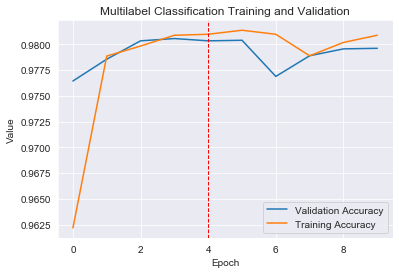

In [71]:
import matplotlib.pyplot as plt

plt.clf()
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.plot(hist_df['accuracy'], label='Training Accuracy')
plt.axvline(x = 4, linewidth=1, color='r', linestyle = "--")

plt.title('Multilabel Classification Training and Validation')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

### Conclusion:

In this notebook we prepared a bidirectional LSTM to train our model to correctly classify toxic comments. We randomly sampled 10% of the original dataset in order to decrease the needed computational time. We then quickly checked our data for missing values and NaNs, and then proceeded with our embeddings. We investigated the use of multiple GLOVE pre-trained embeddings and found that the 840B was the most effective given the extent of the dataset at hand. We leave our trained model with an **accuracy of approximately 98% for both training and validation.**

In the next notebook, we will take a closer look at the comparison between the different GLOVE embeddings and compared the accuracies of the training and validation datasets there.